In [136]:
import os
import subprocess
import time
import re

import matplotlib.pyplot as plt

In [137]:
# Environment variables

topology_file="scenario.imn"
bandwidth="100000000"
scenario_id="i2006"
delay="10000"
fluxes="1"

# Define the topology
links = [
    "router1:pc1",
    "router1:pc3",
    "router2:pc2",
    "router2:pc4",
    "router2:router1"
]

In [138]:
# create logdir if it doesn't exist

log_dir = "./log"
os.makedirs(log_dir, exist_ok=True)

In [ ]:
def run_iperf_and_capture_data(client_pc, server_ip, scenario_id, size="100M", parallel="1", interval="1"):
    cmd = [
        "sudo", "himage", f"{client_pc}@{scenario_id}",
        "iperf", "-c", server_ip, "-n", size, "-P", parallel, "-i", interval
    ]

    print("=" * 56)
    print(f"Running TCP test from {client_pc} to {server_ip}...")

    process = subprocess.run(cmd, capture_output=True, text=True)
    output = process.stdout

    pattern = re.compile(r"\[\s*\d+\]\s+([\d.]+)-([\d.]+)\s+sec\s+([\d.]+)\s+MBytes\s+([\d.]+)\s+Mbits/sec")
    results = pattern.findall(output)

    if results:
        # Remove o último item se for um resumo (intervalo total)
        if results and results[-1][0] == "0.0000":
            results = results[:-1]

        time_points = []
        transfers = []
        bandwidths = []

        for start, end, transfer, bandwidth in results:
            time_points.append(float(end))
            transfers.append(float(transfer))
            bandwidths.append(float(bandwidth))

        return time_points, transfers, bandwidths
    else:
        print("Nenhum resultado encontrado na saída do iperf.")
        print("Saída bruta:")
        print(output)
        return [], [], []

In [ ]:

def plot_iperf_graph(time_points, transfers, bandwidths, title="Bandwidth Over Time"):
    if not time_points or not bandwidths:
        print("Vetores vazios, nada a plotar.")
        return

    plt.figure(figsize=(10, 5))
    plt.plot(time_points, bandwidths, marker='o', linestyle='-', color='blue')
    plt.plot(time_points, transfers, marker='x', linestyle='--', color='red')
    plt.title(title)
    plt.xlabel("Tempo (s)")
    plt.ylabel("Largura de Banda (Mbps)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [141]:
# link configuration
def configure_links(bandwidth, delay, loss, scenario_id):
    for link in links:
        subprocess.run(
            ["sudo", "vlink", "-bw", bandwidth, "-dly", delay, f"{link}@{scenario_id}"],
            stdout=subprocess.DEVNULL
        )

    time.sleep(1)

    # Check status
    for link in links:
        subprocess.run(
            ["sudo", "vlink", "-s", f"{link}@{scenario_id}"]
        )

In [142]:
# Configure computers...

def configure_computers(scenario_id):
    # Start iperf servers
    subprocess.Popen(
        ["sudo", "himage", f"pc2@{scenario_id}", "iperf", "-s"],
        stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
    )
    subprocess.Popen(
        ["sudo", "himage", f"pc4@{scenario_id}", "iperf", "-s"],
        stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
    )

    # Background UDP traffic
    subprocess.Popen(
        ["sudo", "himage", f"pc1@{scenario_id}", "iperf", "-c", "10.0.3.20", "-u", "-t", "100000", "-b", "10M"],
        stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
    )
    

In [ ]:
def starts_simulation(scenario_id):
    subprocess.run(
        ["sudo", "imunes", "-b", "-e", scenario_id, topology_file],
        stdout=subprocess.DEVNULL
    )

def stop_simulation(scenario_id):
    subprocess.run(
        ["sudo", "imunes", "-b", "-e", scenario_id], 
        stdout=subprocess.DEVNULL
    )
    

In [ ]:
def run_imunes_simulation(
    topology_file="scenario.imn",
    bandwidth="100000000",
    scenario_id="i2002",
    delay="10000",
    fluxes="1"
):
    # Start simulation
    print("=" * 56)
    print(f"Starting IMUNES simulation with scenario ID: {scenario_id}")
    starts_simulation(scenario_id)
    time.sleep(1)

    # Configure links
    print("=" * 56)
    print("Simulation started, configuring links...")
    configure_links(bandwidth, delay, 0, scenario_id)
    time.sleep(1)

    # Configure computers
    print("=" * 56)
    print("Configuring computers...")
    configure_computers(scenario_id)
    time.sleep(1)

    # Run iperf tests
    print("=" * 56)
    time_pts, transfers, bandwidths = run_iperf_and_capture_data(client_pc="pc3",server_ip="10.0.4.20",scenario_id=scenario_id,)

    # Stop simulation
    print("=" * 56)
    print(f"Stopping IMUNES simulation with scenario ID: {scenario_id}")
    stop_simulation(scenario_id)
    print("Simulation stopped")

    return time_pts, transfers, bandwidths



Starting IMUNES simulation with scenario ID: i2006


Experiment ID i2006 already in use, trying i1f8.



Simulation started, configuring links...
pc1:router1@i2006:
	bandwidth 100Mbps
	delay 10ms
pc3:router1@i2006:
	bandwidth 100Mbps
	delay 10ms
router2:pc2@i2006:
	bandwidth 100Mbps
	delay 10ms
router2:pc4@i2006:
	bandwidth 100Mbps
	delay 10ms
router1:router2@i2006:
	bandwidth 100Mbps
	delay 10ms
Configuring computers...
Running TCP test from pc3 to 10.0.4.20...


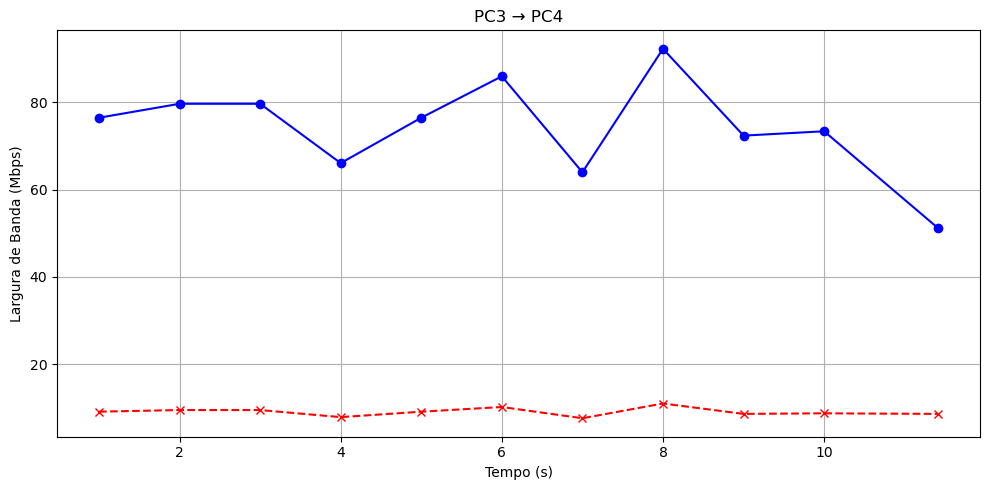

Stopping IMUNES simulation with scenario ID: i2006
Simulation stopped


couldn't open "/var/run/imunes/i2006/runningVars": no such file or directory
    while executing
"open $runtimeDir/$eid/runningVars r"
    (procedure "readRunningVarsFile" line 8)
    invoked from within
"readRunningVarsFile $eid_base"
    invoked from within
"if { $execMode == "interactive" } {
    safePackageRequire Tk "To run the IMUNES GUI, Tk must be installed."

    foreach file "canvas copypaste drawi..."
    (file "/usr/local/lib/imunes/imunes.tcl" line 294)


In [ ]:
time_pts, transfers, bandwidths = run_imunes_simulation(
    topology_file=topology_file,
    bandwidth=bandwidth,
    scenario_id=scenario_id,
    delay=delay,
    fluxes=fluxes
)

plot_iperf_graph(time_pts, transfers, bandwidths, title="PC3 → PC4")

